Average score:  55.0
Choice 1: 0.48194945848375453, Choice 2: 0.5180505415162455


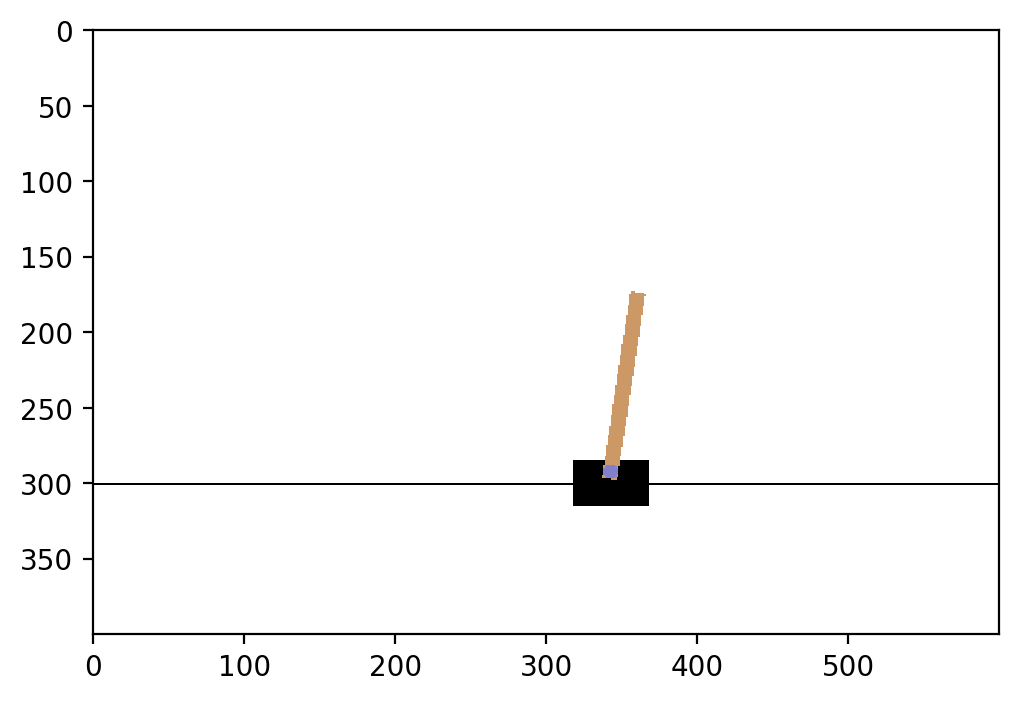

In [1]:

import gym
import random
import numpy as np
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter
from time import sleep

import matplotlib
import matplotlib.pyplot as plt
from IPython import display
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


plt.rcParams['figure.dpi'] = 100

LR = 1e-3

env = gym.make('CartPole-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

def some_random_games_first() :
    for episode in range(5) :
        env.reset()
       
        for t in range(goal_steps) :
            #env.render()
            render(env) 
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
           
            if done:
                break

def render(env):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    env.step(env.action_space.sample())

def initial_population() :
    training_data = []
    scores = []
    accepted_scores = []
    
    for _ in range(initial_games):
        score = 0
        game_memory = []
        prev_observation = []
        
        for _ in range(goal_steps):
            action = random.randrange(0, 2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
                
        if score >= score_requirements:
            accepted_scores.append(score)
            for data in game_memory:
                if data[1] == 1:
                    output = [0,1]
                elif data[1] == 0:
                    output = [1,0]
                    
                training_data.append([data[0], output])
            
        env.reset()
        scores.append(score)
        
        
    training_data_save = np.array(training_data)
    np.save('saved.npy', training_data_save)
    
    print('Average Accepted Score: ', mean(accepted_scores))
    print('Median Accepted Score: ', median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data
    

    
def neural_network_model(input_size):
    network = input_data(shape=[None, input_size,1], name='input')
    
    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 512, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)    

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)
    
    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer = 'adam', learning_rate = LR, loss='categorical_crossentropy', name='targets')
    
    model = tflearn.DNN(network, tensorboard_dir='log')
    return model
    
def train_model(training_data, model=False):
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]), 1)
    y = [i[1] for i in training_data]
    
    if not model:
        model = neural_network_model(input_size=len(X[0]))
    
    model.fit({'input':X},{'targets' : y}, n_epoch=n_epoch, snapshot_step=500, show_metric=True, run_id='openaicartpole')
    
    return model
           


goal_steps = 500
score_requirements = 50
initial_games = 100000
n_epoch=3


training_data = initial_population()



model = train_model(training_data)


scores = []
choices = []


for each_game in range(10):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    
    for _ in range(goal_steps):
        #env.render()
        render(env) # just update the data        

        
        if len(prev_obs) == 0 :
            action = random.randrange(0,2)
        else:
            action = np.argmax(model.predict(prev_obs.reshape(-1, len(prev_obs), 1))[0])
            
        choices.append(action)
        
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        if done:
            break
        
    scores.append(score)

print('Average score: ', sum(scores)/len(scores))
print('Choice 1: {}, Choice 2: {}'.format(choices.count(1)/len(choices), 
     choices.count(0)/len(choices)))

env.close()

